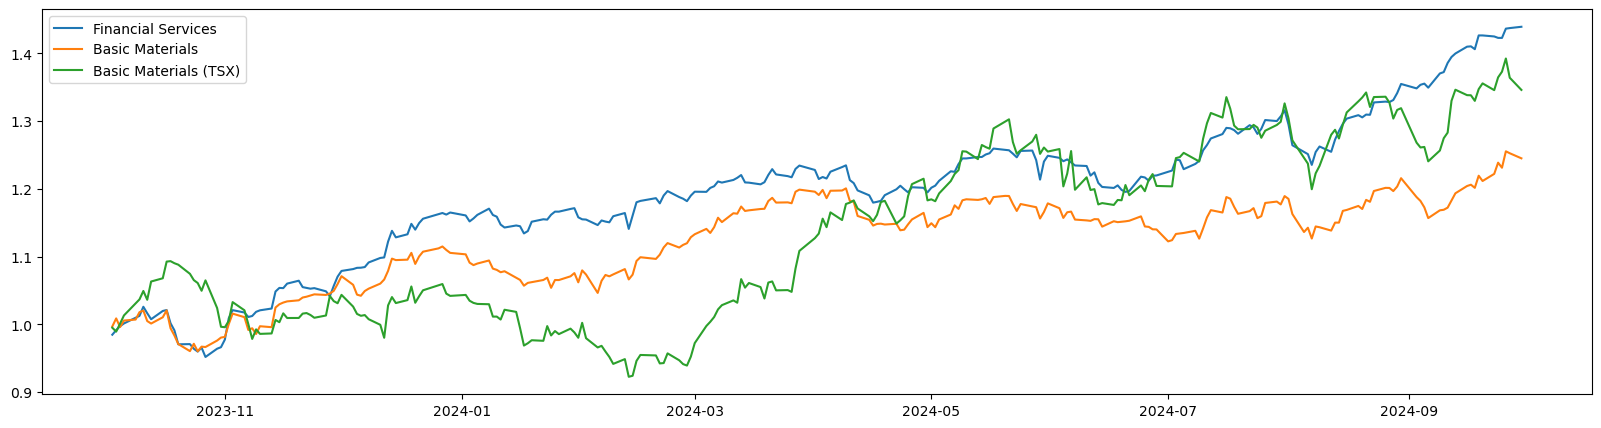

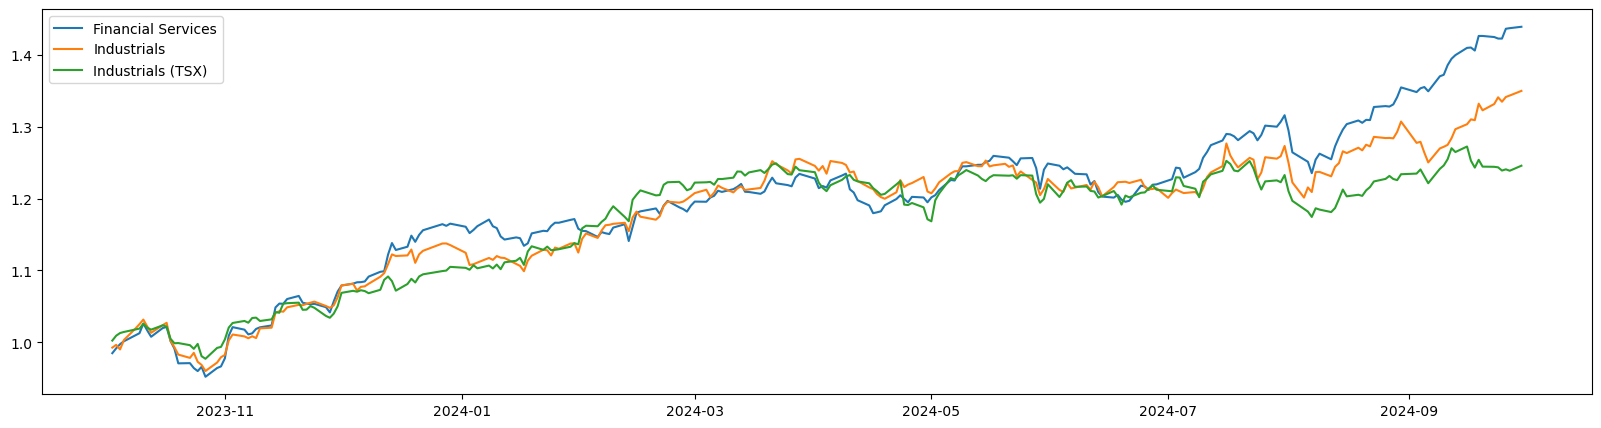

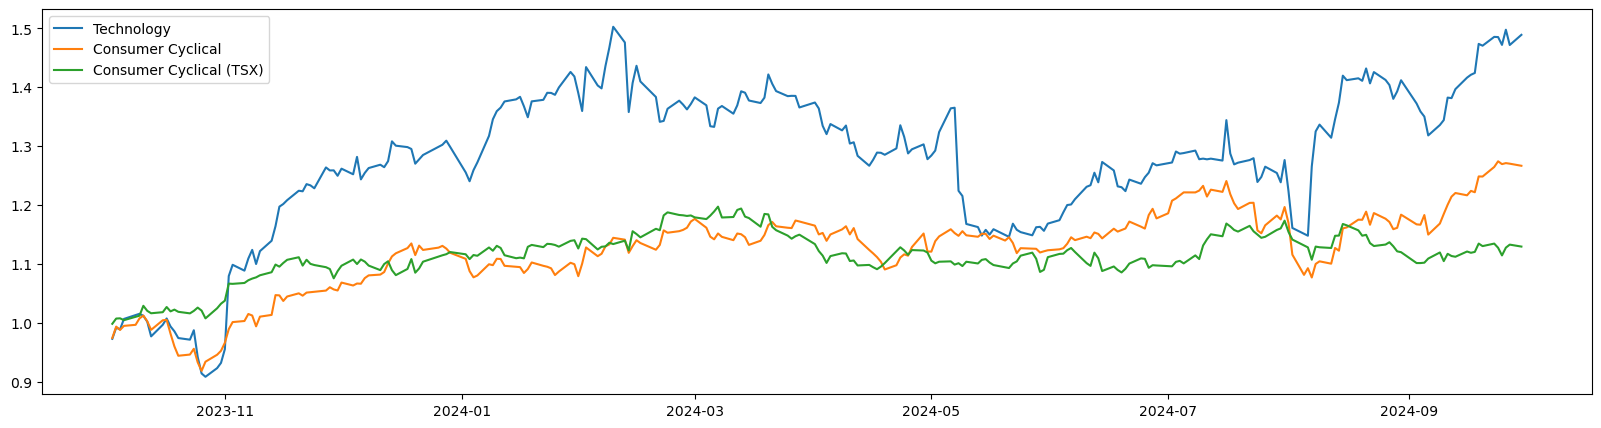

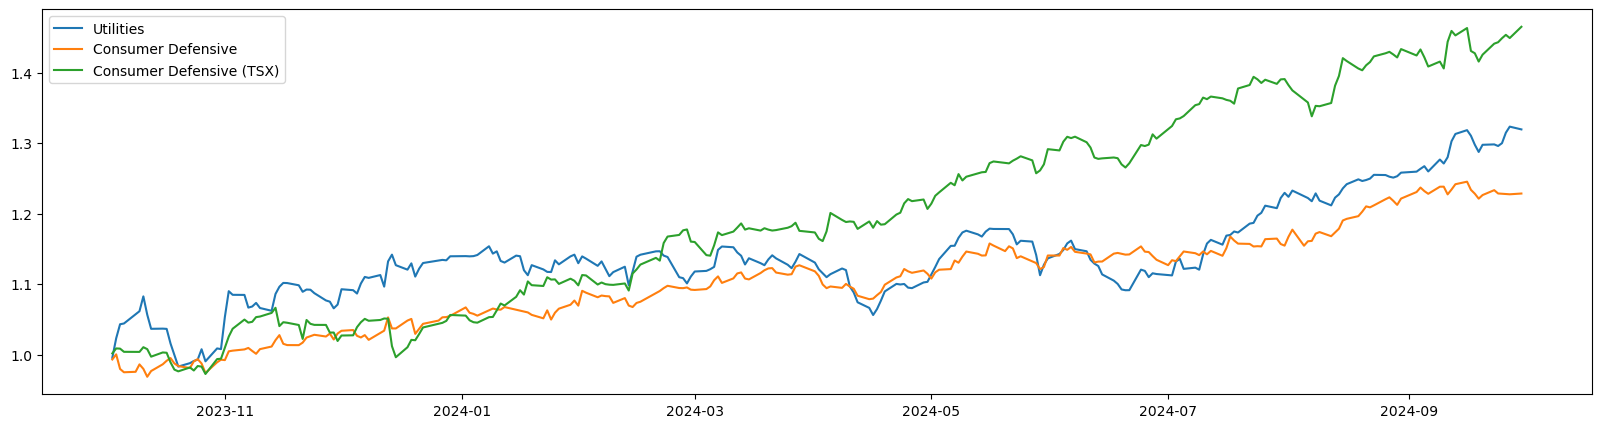

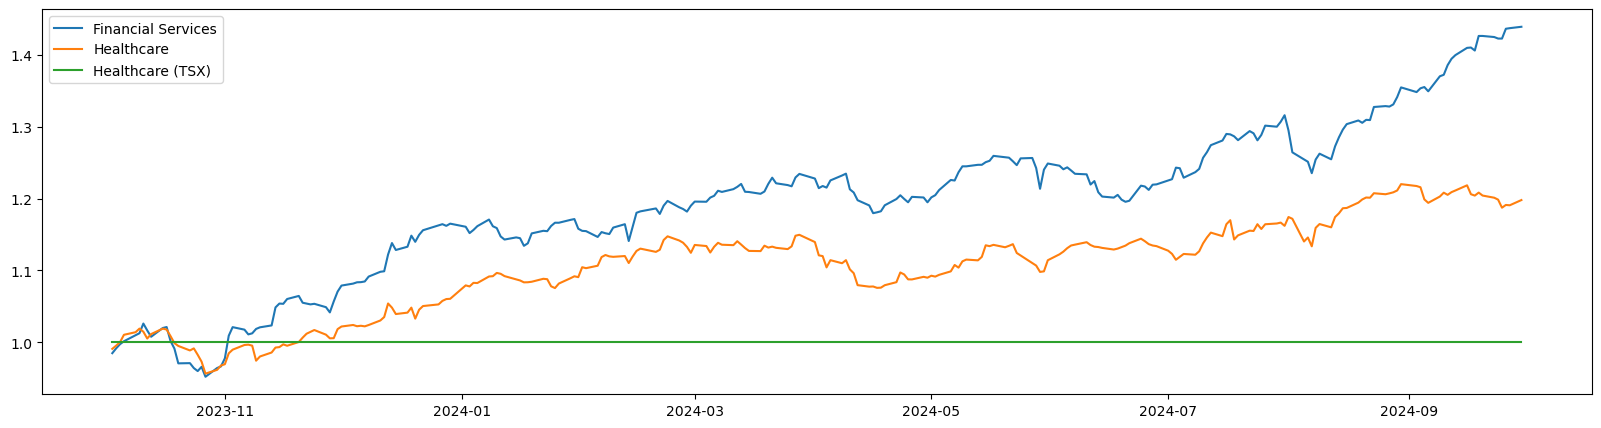

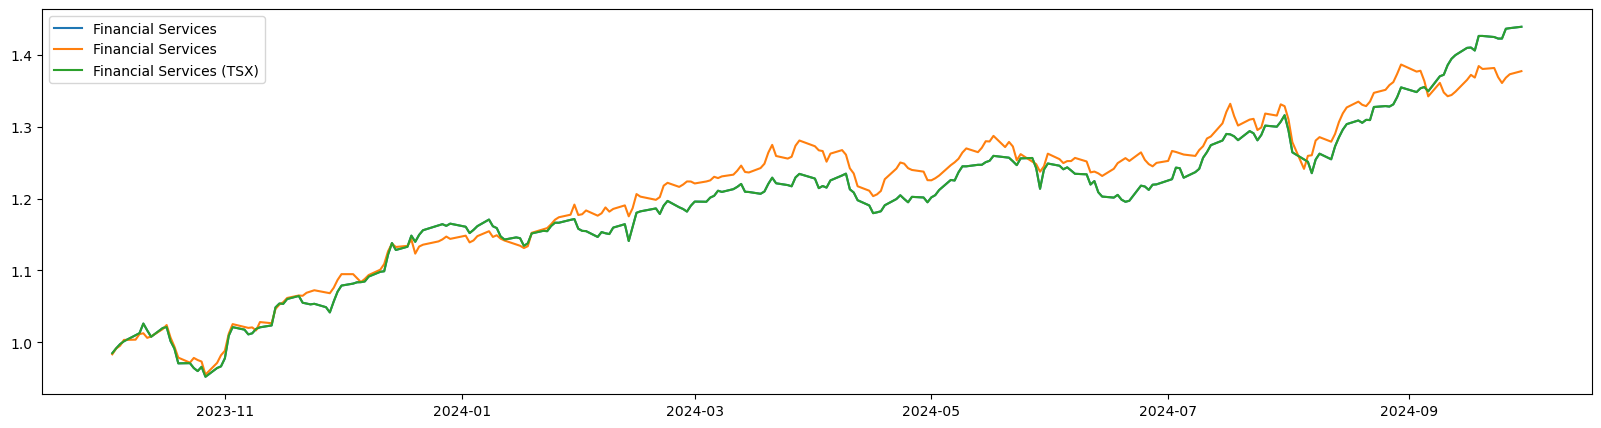

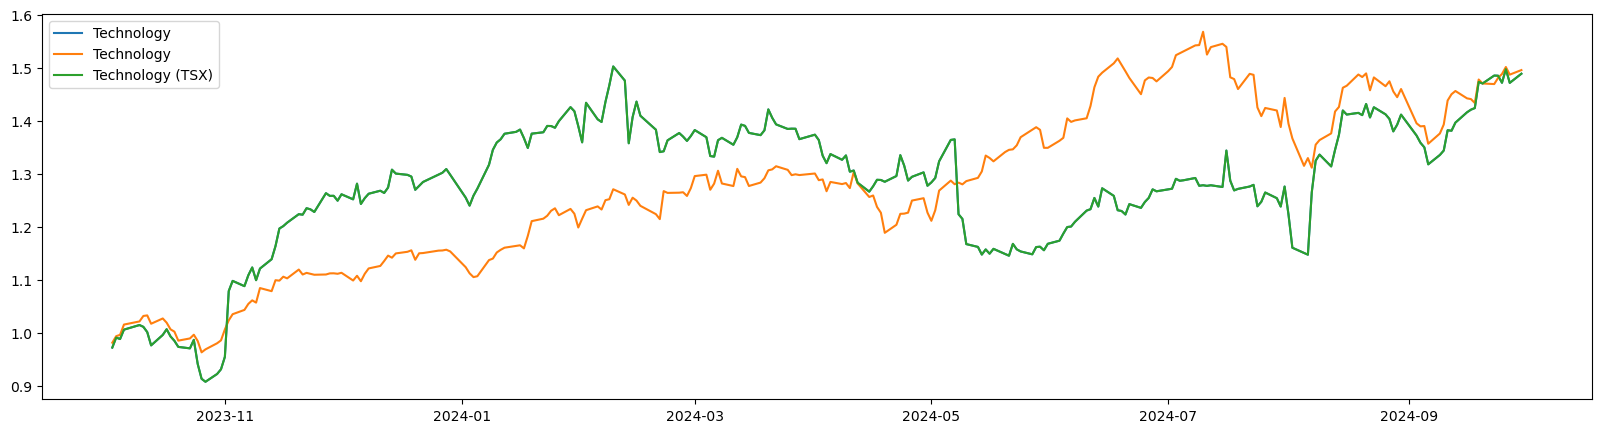

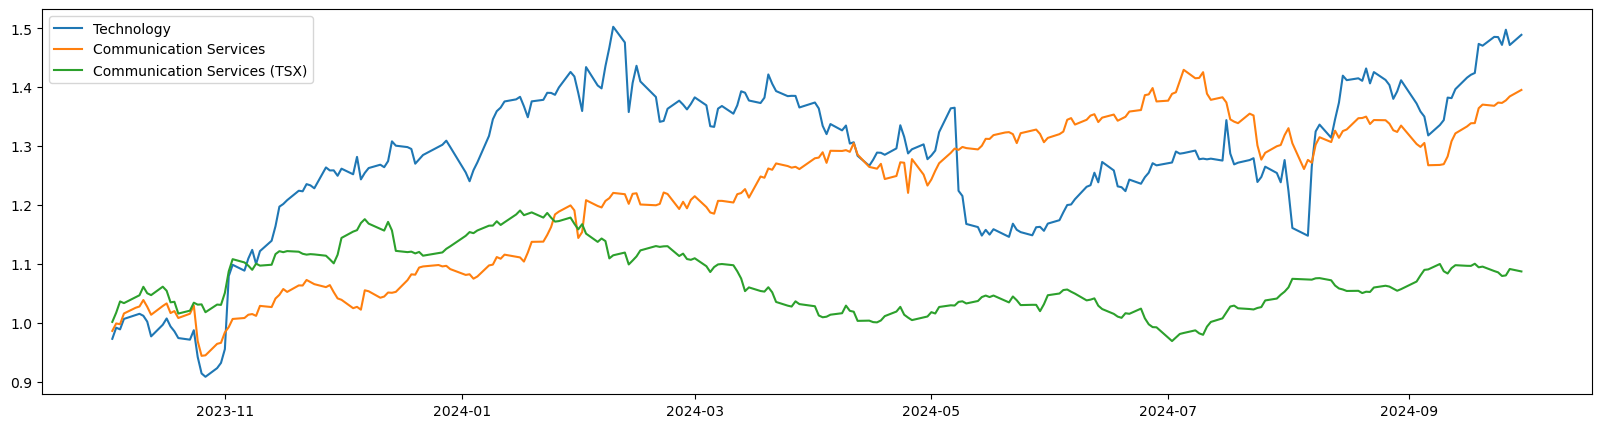

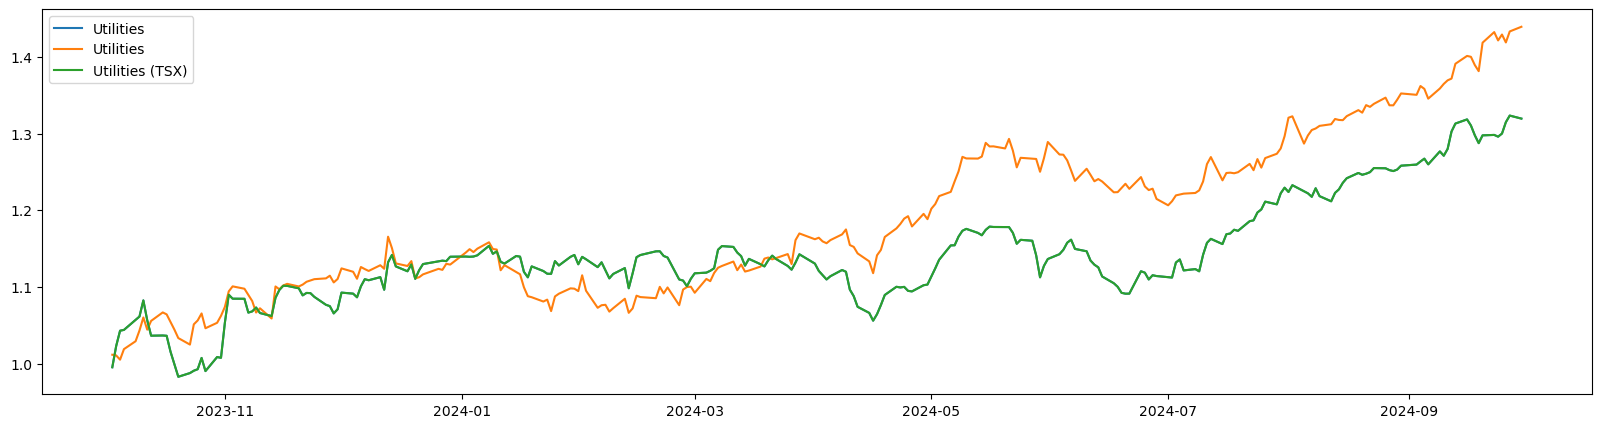

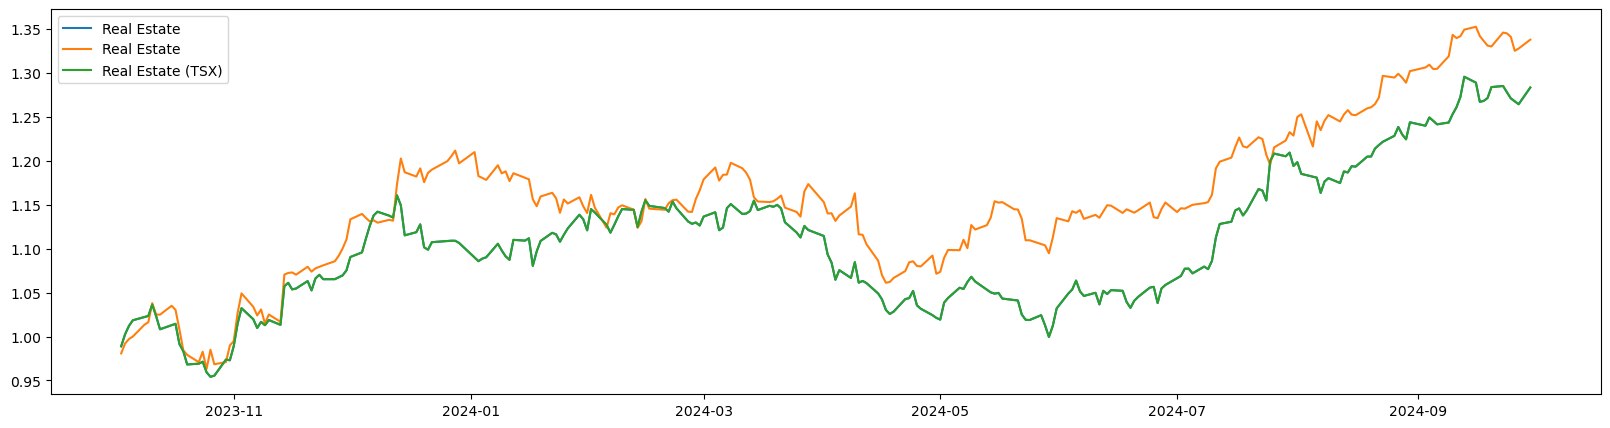

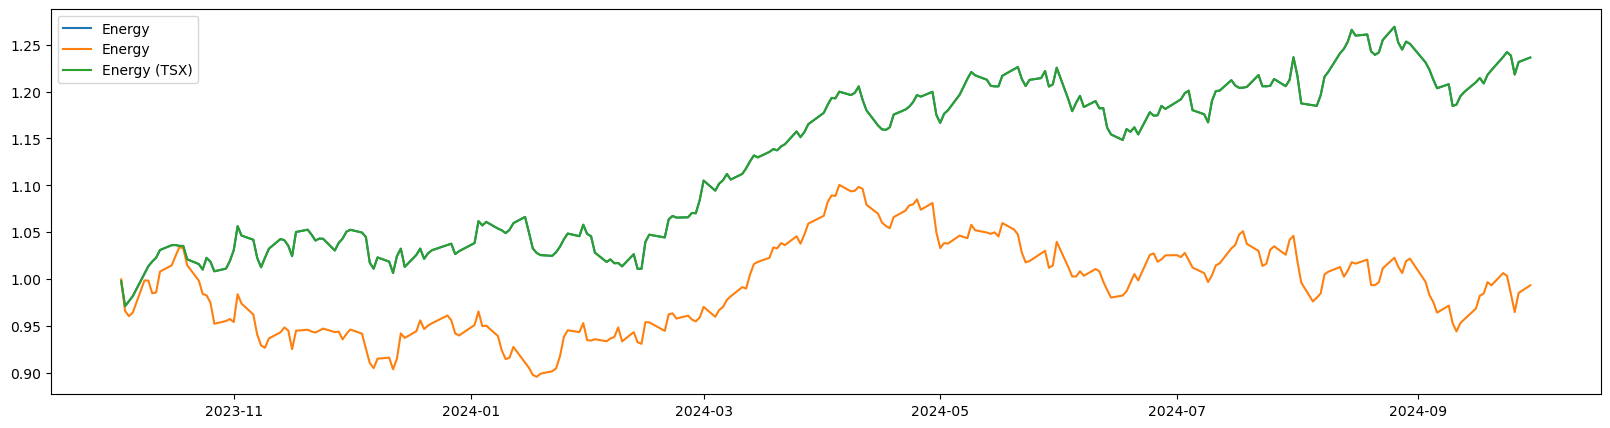

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import threading

attributes = ['sector', 'exchange', 'currency', 'marketCap']
start_date = '2023-10-01'
end_date = '2024-10-01'

# Each industry is mapped to (% share of S&P500, % share of TSX60, S&P industry ticker, TSX60 capped industry ticker)
# Note that the TSX60 capped industry tickers do not have historical data available on Yahoo Finance, thus tsx_sectors() differs from sp_sectors()
# To obtain values for % share, run market_by_sector('SP500') and market_by_sector('TSX60'), respectively (see next cell)
sectors = {
    'Basic Materials': (0.0171, 0.0849, '^SP500-15', '^GSPTTMT'),
    'Industrials': (0.0719, 0.1311, '^SP500-20', '^GSPTTIN'),
    'Consumer Cyclical': (0.1075, 0.0531, '^SP500-25', '^GSPTTCD'),
    'Consumer Defensive': (0.0576, 0.0509, '^SP500-30', '^GSPTTCS'),
    'Healthcare': (0.1014, 0.0000, '^SP500-35', '^GSPTTHC'),
    'Financial Services': (0.1303, 0.3387, '^SP500-40', '^SPTTFS'),
    'Technology': (0.3045, 0.0963, '^SP500-45', '^SPTTTK'),
    'Communication Services': (0.1340, 0.0304, '^SP500-50', '^GSPTTTS'),
    'Utilities': (0.0235, 0.0318, '^SP500-55', '^GSPTTUT'),
    'Real Estate': (0.0207, 0.0062, '^SP500-60', '^GSPTTRE'),
    'Energy': (0.0315, 0.1766, '^SP500-1010', '^SPTTEN')
}

# adds ticker info to data df
def get_data(ticker, data, history):
    yf_data = yf.Ticker(ticker).info
    # check if stock is CAD or USD
    if('currency' not in yf_data or yf_data['currency'] not in ['USD', 'CAD']):
        data.drop(ticker, inplace=True)
        print('Dropped', ticker)
        return
    for att in attributes:
        if(att not in yf_data):
            print(ticker, 'missing', att)
            continue
        data.loc[ticker, att] = yf_data[att]
    hist = yf.Ticker(ticker).history(start=start_date, end=end_date)
    history[ticker] = hist['Close'].pct_change().dropna()
    volume = hist['Volume'].resample('MS').sum()
    # Take all months with >= 18 trading days for volume calculation
    volume.drop([month for month in volume.index if hist.resample('MS').size().loc[month] < 18], inplace=True)
    # check if stock has at least 100,000 average monthly volume
    if(volume.mean() < 1e5):
        data.drop(ticker, inplace=True)

# returns df containing all ticker info
def get_tickers(file_name='Tickers.csv'):
    tickers = pd.read_csv(file_name, header=None)
    data = pd.DataFrame(index=[ticker for ticker in tickers[0]])
    history = {}
    threads = [threading.Thread(target=get_data, args=(ticker,data,history)) for ticker in tickers[0]]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    return (data, history)

# returns function of stocks to sectors as given by f
def calc(data, history, f):
    sector_metric = {stock:{} for stock in data.index}
    for sector in sectors:
        history[sectors[sector][2]] = yf.Ticker(sectors[sector][2]).history(start=start_date, end=end_date)['Close'].pct_change().dropna()
        for stock in data.index:
            df = pd.DataFrame({stock: history[stock], sector: history[sectors[sector][2]]}).dropna()
            # calculate metric given a function f
            sector_metric[stock][sector] = f(df, stock, sector)
    return sector_metric

def beta(df, stock, sector):
    return df[stock].cov(df[sector])/df[sector].var()

def corr(df, stock, sector):
    return df[stock].corr(df[sector])

# returns df containing history for each sector in TSX60
# since historical data for each sector is unavailable, we take the weighted average of all stocks in each sector
def tsx_sectors():
    data, history = get_tickers('TSX60.csv')
    sector_history = pd.DataFrame({sector: 0 for sector in sectors}, index=history[data.index[0]].index)
    total_market_cap = {sector: 0 for sector in sectors}
    for stock in history:
        total_market_cap[data['sector'].loc[stock]] += data['marketCap'].loc[stock]
    for stock in history:
        sector = data['sector'].loc[stock]
        sector_history[sector] += history[stock]*data['marketCap'].loc[stock]/total_market_cap[sector]
    return sector_history

# returns df containing history for each sector in S&P500
def sp_sectors():
    history = {sector: yf.Ticker(sectors[sector][2]).history(start=start_date, end=end_date)['Close'].pct_change().dropna() for sector in sectors}
    return pd.DataFrame(history, index=list(history.values())[0].index)

def aggregate_pct_change(history, stock):
    result = pd.Series(index=history[stock].index)
    prev = 1
    for day in history[stock].index:
        result[day] = prev*(1+history[stock][day])
        prev = result[day]
    return result

# data, history = get_tickers()
# sector_beta = calc(data, history, beta)
# sector_corr = calc(data, history, corr)
tsx_by_sector = tsx_sectors()
sp_by_sector = sp_sectors()
# sector_metric = {stock:{} for stock in data.index}
for sector in sectors:
    best = 0
    best_sector = ''
    for tmp in sectors:
        if(tmp == 'Healthcare'):
            continue
        if(tsx_by_sector[tmp].corr(sp_by_sector[sector]) > best):
            best = tsx_by_sector[tmp].corr(sp_by_sector[sector])
            best_sector = tmp
    a = aggregate_pct_change(tsx_by_sector, best_sector)
    c = aggregate_pct_change(tsx_by_sector, sector)
    b = aggregate_pct_change(sp_by_sector, sector)
    plt.figure(figsize=(20, 5))
    plt.plot(a.index, a, label=best_sector)
    plt.plot(b.index, b, label=sector)
    plt.plot(c.index, c, label=sector + ' (TSX)')
    plt.legend()
    plt.show()


In [ ]:
# adds market cap of ticker to data table
def ticker_by_sector(ticker, data):
    yf_data = yf.Ticker(ticker).info
    data[yf_data['sector']] += yf_data['marketCap']

# prints percentage of index in each sector
def market_by_sector(index):
    tickers = pd.read_csv(index+'.csv', header=None)
    data = {sector: 0 for sector in sectors}
    threads = [threading.Thread(target=ticker_by_sector, args=(ticker,data)) for ticker in tickers[0]]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    sum = 0
    for sector in data:
        sum += data[sector]
    for sector in data:
        print(sector, 'accounts for', round(data[sector]/sum*100, 2), 'percent of', index)